In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from astropy.time import Time, TimeDelta

In [2]:
mjd_unixtimestamp_offset = 10587.5
seconds_in_day = 3600 * 24

def mjd2unixtimestamp(m):
    return (m - mjd_unixtimestamp_offset) * seconds_in_day

In [3]:
def load_file(path):
    ncols = 7
    data = np.fromfile(path, sep=' ')
    return data.reshape((data.size // ncols, ncols))

The file below is obtained by running the `photo_planning.script` GMAT script.

In [4]:
data = load_file('/home/daniel/jupyter_notebooks/dslwp/EarthMoonPosDSWLP.txt')
t = Time(mjd2unixtimestamp(data[:,0]), format='unix')

In [5]:
def distance(x):
    return np.sqrt(np.sum(x**2, axis=1))

def angle(x):
    return np.rad2deg(np.arccos(x[:,0] / distance(x)))

def angular_radius(x, r):
    return np.rad2deg(np.arcsin(r / distance(x)))

def angle_between(x, y):
    return np.rad2deg(np.arccos(np.sum(x * y, axis = 1)/(distance(x)*distance(y))))

In [6]:
earth_angle = angle(data[:,1:4])
moon_angle = angle(data[:,4:7])
earth_radius = 6378.1
moon_radius = 1737.1
earth_angular_radius = angular_radius(data[:,1:4], earth_radius)
moon_angular_radius = angular_radius(data[:,4:7], moon_radius)

In [7]:
camera_fov_long = 18.5
camera_fov_short = 14

In [8]:
photo_times = Time(['2019-06-30 05:51:20', '2019-06-30 05:52:20', '2019-06-30 05:53:20',
                    '2019-06-30 06:29:50', '2019-06-30 06:30:50', '2019-06-30 06:31:50',
                    '2019-07-02 18:56:00', '2019-07-02 18:57:00', '2019-07-02 18:58:00',
                    '2019-07-02 19:31:45', '2019-07-02 19:32:45', '2019-07-02 19:33:45']) + TimeDelta(20, format='sec')
obs_times = Time(['2019-06-30 05:30:00', '2019-07-01 05:30:00', '2019-07-02 18:00:00',
                  '2019-07-03 06:00:00', '2019-07-04 06:30:00', '2019-07-05 07:30:00'])
obs_times_end = obs_times + TimeDelta(2*3600, format='sec')
#calibration_time = Time('2018-10-6 13:55')
#calibration_time = Time('2018-11-8 9:40')

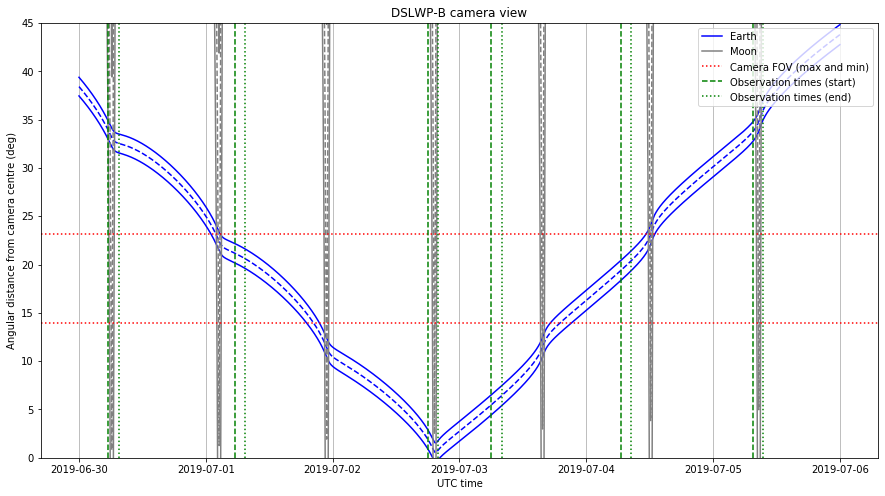

In [9]:
plt.figure(figsize = [15,8], facecolor='w')
plt.plot(t.datetime, earth_angle, color = 'blue', linestyle = '--')
plt.plot(t.datetime, earth_angle-earth_angular_radius, color = 'blue', label='Earth')
plt.plot(t.datetime, earth_angle+earth_angular_radius, color = 'blue')
plt.plot(t.datetime, moon_angle, color = 'grey', linestyle = '--')
plt.plot(t.datetime, moon_angle-moon_angular_radius, color = 'grey', label='Moon')
plt.plot(t.datetime, moon_angle+moon_angular_radius, color = 'grey')
plt.axhline(y=camera_fov_short, linestyle=':', color = 'red')
plt.axhline(y=np.sqrt(camera_fov_short**2 + camera_fov_long**2), linestyle=':', color = 'red', label='Camera FOV (max and min)')
plt.ylim([0,45])
for j,obs in enumerate(obs_times.datetime):
    if j == 0:
        plt.axvline(x=obs, color = 'green', label='Observation times (start)', linestyle = '--')
    else:
        plt.axvline(x=obs, color = 'green', linestyle = '--')
for j,obs in enumerate(obs_times_end.datetime):
    if j == 0:
        plt.axvline(x=obs, color = 'green', label='Observation times (end)', linestyle = ':')
    else:
        plt.axvline(x=obs, color = 'green', linestyle = ':')
#plt.axvline(x=calibration_time.datetime, color = 'orange', label = 'Calibration image')
plt.grid(axis='x')
plt.legend(loc='upper right')
plt.ylabel('Angular distance from camera centre (deg)')
plt.xlabel('UTC time')
plt.title('DSLWP-B camera view');

In [10]:
def plot_view(start = None, end = None, plot_obstimes = False, zoom_factor = 1):
    if start is None or end is None:
        sel = np.arange(t.size)
    else:
        sel = (t >= start) & (t <= end)
    plt.figure(figsize = [15,8], facecolor='w')
    plt.plot(t[sel].datetime, earth_angle[sel], color = 'blue', linestyle = '--')
    plt.plot(t[sel].datetime, earth_angle[sel]-earth_angular_radius[sel], color = 'blue', label='Earth')
    plt.plot(t[sel].datetime, earth_angle[sel]+earth_angular_radius[sel], color = 'blue')
    plt.plot(t[sel].datetime, moon_angle[sel], color = 'grey', linestyle = '--')
    plt.plot(t[sel].datetime, moon_angle[sel]-moon_angular_radius[sel], color = 'grey', label='Moon')
    plt.plot(t[sel].datetime, moon_angle[sel]+moon_angular_radius[sel], color = 'grey')
    plt.axhline(y=camera_fov_short/zoom_factor, linestyle=':', color = 'red')
    plt.axhline(y=np.sqrt(camera_fov_short**2 + camera_fov_long**2)/zoom_factor, linestyle=':', color = 'red', label='Camera FOV (max and min)')
    plt.ylim([0,25/zoom_factor])
    plt.xlim([t[sel][0].datetime, t[sel][-1].datetime])
    if plot_obstimes:
        for j,obs in enumerate(photo_times.datetime):
            if j == 0:
                plt.axvline(x=obs, color = 'green', label='Photo times', linestyle = '--')
            else:
                plt.axvline(x=obs, color = 'green', linestyle = '--')
    plt.grid(axis='x')
    plt.legend(loc='upper right')
    plt.ylabel('Angular distance from camera centre (deg)')
    plt.xlabel('UTC time')
    plt.title('DSLWP-B camera view');

In [11]:
earth_moonrim_angle = angle_between(data[:,1:4], data[:,4:7]) - moon_angular_radius

def plot_earthrise(start = None, end = None, both_edges = False, plot_obstimes = False):
    if start is None or end is None:
        sel = np.arange(t.size)
    else:
        sel = (t >= start) & (t <= end)
    plt.figure(figsize = [15,8], facecolor='w')
    if both_edges:
        plt.plot(t[sel].datetime, earth_moonrim_angle[sel] - earth_angular_radius[sel], color = 'blue', label = 'Earth rim')
        plt.plot(t[sel].datetime, earth_moonrim_angle[sel] + earth_angular_radius[sel], color = 'blue')
    else:
        plt.plot(t[sel].datetime, earth_moonrim_angle[sel], color = 'blue', label = 'Earth centre')
    plt.axhline(y=0, linestyle=':', color = 'grey', label = 'Moon rim')
    plt.ylim([-10,10])
    plt.xlim([t[sel][0].datetime, t[sel][-1].datetime])
    plt.legend()
    if both_edges == True:
        plt.gca().xaxis.set_major_locator(mdates.MinuteLocator(range(0,60,5)))
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d %H:%M'))
        plt.xticks(rotation=45)
    else:
        plt.gca().xaxis.set_major_locator(mdates.DayLocator())
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    if plot_obstimes:
        for j,obs in enumerate(photo_times.datetime):
            if j == 0:
                plt.axvline(x=obs, color = 'green', label='Photo times (start)', linestyle = '--')
            else:
                plt.axvline(x=obs, color = 'green', linestyle = '--')
        #for j,obs in enumerate(photo_times_end.datetime):
        #    if j == 0:
        #        plt.axvline(x=obs, color = 'green', label='Observation times (end)', linestyle = ':')
        #    else:
        #        plt.axvline(x=obs, color = 'green', linestyle = ':')
    plt.grid(axis='x')
    plt.ylabel('Angular distance from Moon rim (deg)')
    plt.xlabel('UTC time')
    plt.title('DSLWP-B Earthrise view')

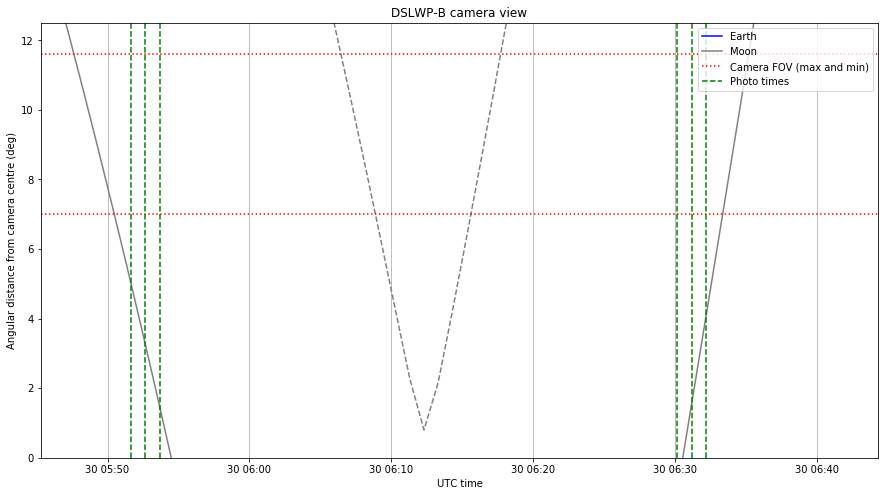

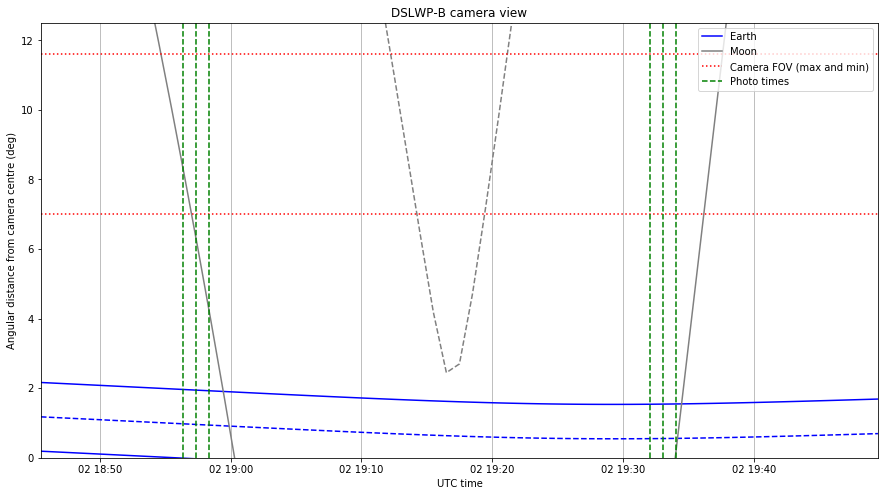

In [12]:
plot_view('2019-06-30 05:45', '2019-06-30 06:45', plot_obstimes = True, zoom_factor = 2)
plot_view('2019-07-02 18:45', '2019-07-02 19:50', plot_obstimes = True, zoom_factor = 2)

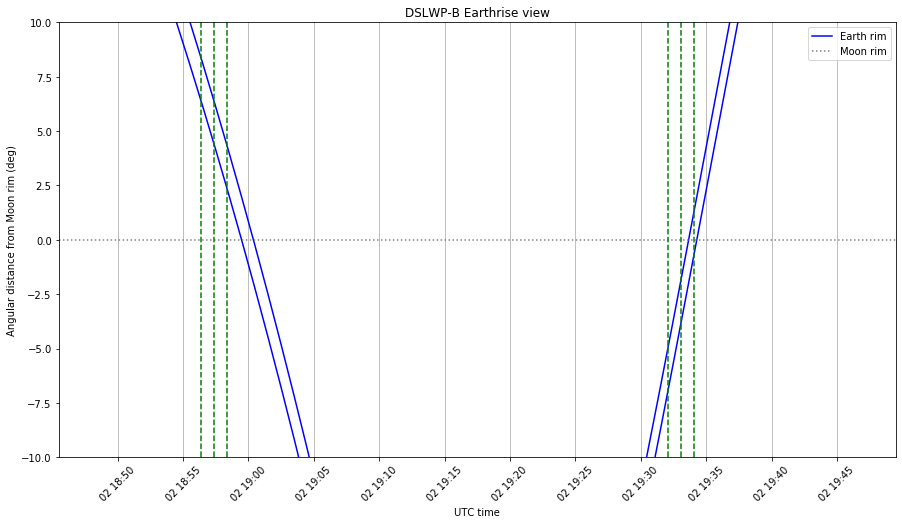

In [13]:
plot_earthrise(start = '2019-07-02 18:45', end = '2019-07-02 19:50', both_edges = True, plot_obstimes = True)

In [14]:
for photo in photo_times:
    moon_separation = np.interp((photo-t[0]).jd, (t-t[0]).jd, moon_angle-moon_angular_radius)
    print(photo, 'Moon separation:', moon_separation)

2019-06-30 05:51:40.000 Moon separation: 4.985609071300166
2019-06-30 05:52:40.000 Moon separation: 3.2534726111629837
2019-06-30 05:53:40.000 Moon separation: 1.4831821253877489
2019-06-30 06:30:10.000 Moon separation: -0.9352703168863021
2019-06-30 06:31:10.000 Moon separation: 1.5330906784066798
2019-06-30 06:32:10.000 Moon separation: 4.018388958630757
2019-07-02 18:56:20.000 Moon separation: 8.356619308639145
2019-07-02 18:57:20.000 Moon separation: 6.334771011968048
2019-07-02 18:58:20.000 Moon separation: 4.255154088346641
2019-07-02 19:32:05.000 Moon separation: -6.039114894866719
2019-07-02 19:33:05.000 Moon separation: -2.8836382593738192
2019-07-02 19:34:05.000 Moon separation: 0.3001038116889898


In [15]:
moon_speed_deg_s = np.diff(moon_angle-moon_angular_radius)/np.diff((t-t[0]).sec)
t_moon_speed = t[:-1] + (t[1:] - t[:-1])/2

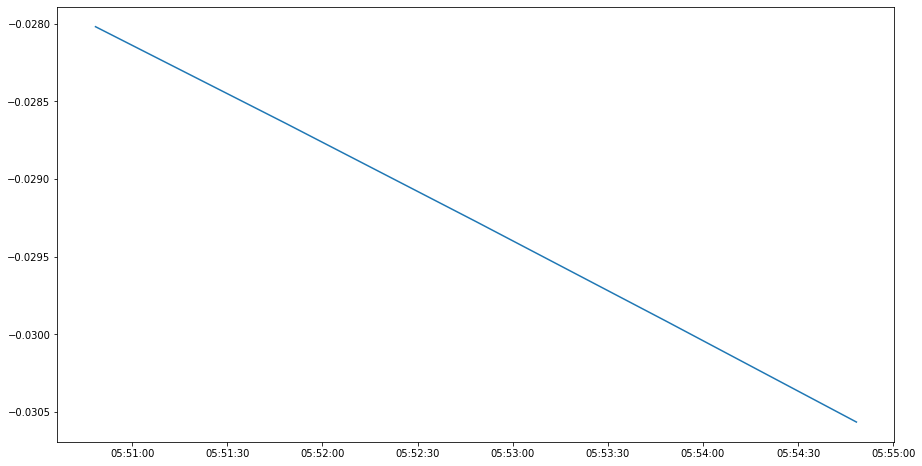

In [16]:
sel = (t_moon_speed >= '2019-06-30 05:50') & (t_moon_speed <= '2019-06-30 05:55')
plt.figure(figsize = [15,8], facecolor='w')
plt.plot(t_moon_speed[sel].datetime, moon_speed_deg_s[sel])

In [17]:
average_speed = np.average(moon_speed_deg_s[sel])
average_speed

-0.02928301496269241

In [18]:
real_separation = 6.47
(real_separation - np.interp((photo_times[1]-t[0]).jd, (t-t[0]).jd, moon_angle-moon_angular_radius))/average_speed

-109.84276697378958

In [19]:
separation_error = 3.25
time_error = np.abs(3.25/average_speed)
time_error

110.98583954352426